In [1]:
import json
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Torch
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset

In [ ]:
# model
from model import LTSFLinear

In [ ]:
warnings.filterwarnings("ignore")

In [2]:
BATCH_SIZE = 8
EPOCHS = 100
TRAIN_TEST_SPLIT = 0.8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "basic_transformer"

## Data processing

In [3]:
df = pd.read_csv('./data/agg_data.csv')
df.columns

Index(['StnPres', 'SeaPres', 'StnPresMax', 'StnPresMaxTime', 'StnPresMin',
       'StnPresMinTime', 'Temperature', 'T Max', 'T Max Time', 'T Min',
       'T Min Time', 'Td dew point', 'RH', 'RHMin', 'RHMinTime', 'WS', 'WD',
       'WSGust', 'WDGust', 'WGustTime', 'Precp', 'PrecpHour', 'PrecpMax10',
       'PrecpMax10Time', 'PrecpMax60', 'PrecpMax60Time', 'SunShine',
       'SunshineRate', 'GloblRad', 'VisbMean', 'EvapA', 'UVI Max',
       'UVI Max Time', 'Cloud Amount', 'TxSoil0cm', 'TxSoil5cm', 'TxSoil10cm',
       'TxSoil20cm', 'TxSoil30cm', 'TxSoil50cm', 'TxSoil100cm'],
      dtype='object')

In [4]:
DROP_COL = ["StnPresMaxTime","StnPresMinTime","T Max Time","UVI Max Time","T Min Time","RHMinTime","WGustTime","PrecpMax10Time","PrecpMax60Time"]
df = df.drop(DROP_COL, axis=1)

In [5]:
df['EvapA'] = df['EvapA'].replace('/', 0)
df['EvapA'] = df['EvapA'].astype(float)
df['Precp'] = df['Precp'].replace('T', 0)
df['Precp'] = df['Precp'].astype(float)
df['PrecpMax10'] = df['PrecpMax10'].replace('T', 0)
df['PrecpMax10'] = df['PrecpMax10'].astype(float)
df['PrecpMax60'] = df['PrecpMax60'].replace('T', 0)
df['PrecpMax60'] = df['PrecpMax60'].astype(float)

In [6]:
df.head()

,StnPres,SeaPres,StnPresMax,StnPresMin,Temperature,T Max,T Min,Td dew point,RH,RHMin,...,EvapA,UVI Max,Cloud Amount,TxSoil0cm,TxSoil5cm,TxSoil10cm,TxSoil20cm,TxSoil30cm,TxSoil50cm,TxSoil100cm
0,1011.3,1013.8,1012.5,1010.5,27.4,32.2,24.7,25.3,89,62,...,5.3,9,3.0,27.9,27.9,27.7,27.7,28.5,27.8,27.7
1,1011.1,1013.6,1012.4,1010.0,27.7,31.5,24.7,25.5,88,63,...,4.2,9,0.8,28.3,28.3,27.7,27.7,28.6,27.9,27.8
2,1010.8,1013.3,1012.1,1009.6,27.6,31.2,25.0,25.5,89,67,...,4.9,9,2.6,28.3,28.3,27.9,27.9,28.7,28.0,27.8
3,1011.0,1013.5,1012.8,1009.5,28.1,32.1,25.1,24.9,83,62,...,-5.7,9,1.8,28.4,28.4,27.9,27.9,28.8,28.1,27.9
4,1012.6,1015.1,1014.6,1011.0,27.0,31.2,24.5,24.3,86,64,...,-5.3,10,5.8,28.0,28.0,27.8,27.9,28.8,28.1,28.0


In [7]:
TARGET = "Temperature"

# Make dataset

In [8]:
class WeatherDataset(Dataset):
    def __init__(self, df, target, window_size=30):
        self.df = df
        self.target = target
        self.window_size = window_size
        self.features = df.columns

    def __len__(self):
        return len(self.df) - self.window_size - 1
    
    def __getitem__(self, idx):
        idx += self.window_size
        window = self.df.iloc[idx-self.window_size:idx]
        target = self.df.iloc[idx+1][self.target]
        features = window[self.features].values
        return features, target
    
dataset = WeatherDataset(df, TARGET)
train_size = int(TRAIN_TEST_SPLIT * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
for idx,(features, target) in enumerate(train_dataloader):
    print(f"Input Shape: {features.shape}, Target Shape: {target.shape}")
    break

Input Shape: torch.Size([8, 30, 32]), Target Shape: torch.Size([8])


In [10]:
# Model
# class WeatherModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(WeatherModel, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)
        
#     def forward(self, x):
#         x, _ = self.lstm(x)
#         x = self.fc(x[:, -1])
#         return x

class WeatherModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WeatherModel, self).__init__()
        self.transformer = nn.Transformer(d_model=input_size, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=512, dropout=0.1)
        self.fc = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        x = self.transformer(x, x)
        x = self.fc(x)
        x = x[:, -1]
        return x
    
test_input = torch.randn(8, 30, 32)
model = WeatherModel(32, 64, 1)
out = model(test_input)
print(out.shape)

torch.Size([8, 1])


c:\Program Files\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [11]:
model = WeatherModel(len(df.columns), 64, 1).to(DEVICE)

# Loss and Optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training

def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        features, target = data
        features, target = features.float().to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            features, target = data
            features, target = features.float().to(DEVICE), target.float().to(DEVICE)
            output = model(features)
            loss = criterion(output, target.unsqueeze(1))
            running_loss += loss.item()
    return running_loss / len(dataloader)

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    train_loss = train(model, train_dataloader, criterion, optimizer)
    test_loss = test(model, test_dataloader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch: {epoch+1}/{EPOCHS}, Train Loss: {train_loss}, Test Loss: {test_loss}")

c:\Program Files\Python311\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch: 1/100, Train Loss: 346.81058303169584, Test Loss: 328.5567105611165
Epoch: 2/100, Train Loss: 277.4650941931683, Test Loss: 254.79634475708008
Epoch: 3/100, Train Loss: 212.05704033893088, Test Loss: 195.47776730855307
Epoch: 4/100, Train Loss: 149.21894048607868, Test Loss: 135.40589714050293
Epoch: 5/100, Train Loss: 97.73387328438137, Test Loss: 85.45334307352702
Epoch: 6/100, Train Loss: 62.16956553251847, Test Loss: 57.27727794647217
Epoch: 7/100, Train Loss: 42.49302546874337, Test Loss: 42.674487272898354
Epoch: 8/100, Train Loss: 33.45855316908463, Test Loss: 35.597843964894615
Epoch: 9/100, Train Loss: 30.4512824182925, Test Loss: 34.899069945017494
Epoch: 10/100, Train Loss: 29.52313769381979, Test Loss: 32.174587885538735
Epoch: 11/100, Train Loss: 28.984818603681482, Test Loss: 32.66836945215861
Epoch: 12/100, Train Loss: 29.231108375217605, Test Loss: 31.458765506744385
Epoch: 13/100, Train Loss: 29.25267107590385, Test Loss: 33.615482807159424
Epoch: 14/100, Train 

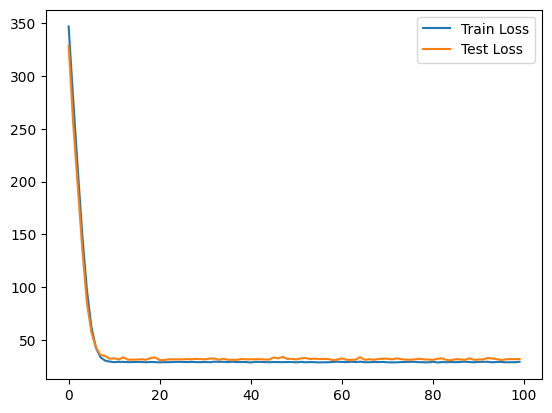

In [12]:
# plot
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

In [13]:
# predict
def predict(model, df, window_size=30):
    model.eval()
    features = df.iloc[-window_size:].values
    features = torch.tensor(features).float().to(DEVICE)
    with torch.no_grad():
        pred = model(features.unsqueeze(0))
    return pred.item()

predict(model, df)

22.234590530395508

In [14]:
# save json
info = {
    "model_name": MODEL_NAME,
    "target": TARGET,
    "features": df.columns.tolist(),
    "window_size": 30,
    "train_test_split": TRAIN_TEST_SPLIT,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "device": DEVICE.type,
    "train_loss": train_losses,
    "test_loss": test_losses
}

with open(f"results/{MODEL_NAME}.json", "w") as f:
    json.dump(info, f)